In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

PATH_COLLECTED_DATA = './computed/collected_data.csv'
PATH_COLLECTED_DATA_REDUCED = './computed/collected_data_reduced_features.csv'

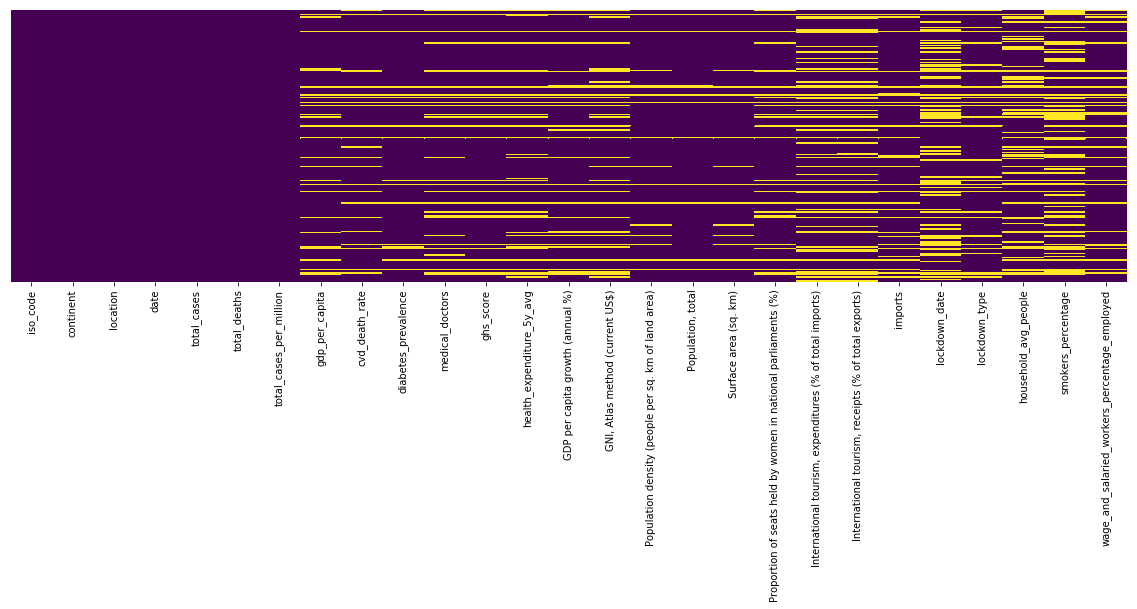

In [2]:
df_complete = pd.read_csv(PATH_COLLECTED_DATA)
df = pd.read_csv(PATH_COLLECTED_DATA_REDUCED)

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

As seen in the other notebook, there are multiple features correlating with `gdp_per_capita`. We want to find out which features can explain the number of cases (more reliable). For clarity we displayed these features below:

In [3]:
corr = df.loc[:, ['total_cases_per_million', 'gdp_per_capita', 'ghs_score',
                  'Population density (people per sq. km of land area)',
                  'International tourism, expenditures (% of total imports)', 'household_avg_people',
                  'wage_and_salaried_workers_percentage_employed']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases_per_million,gdp_per_capita,ghs_score,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)",household_avg_people,wage_and_salaried_workers_percentage_employed
total_cases_per_million,1,0.61,0.19,0.2,0.21,-0.31,0.37
gdp_per_capita,0.61,1,0.53,0.29,0.16,-0.62,0.7
ghs_score,0.19,0.53,1,0.071,-0.025,-0.62,0.54
Population density (people per sq. km of land area),0.2,0.29,0.071,1,0.033,-0.056,0.12
"International tourism, expenditures (% of total imports)",0.21,0.16,-0.025,0.033,1,-0.0056,0.053
household_avg_people,-0.31,-0.62,-0.62,-0.056,-0.0056,1,-0.66
wage_and_salaried_workers_percentage_employed,0.37,0.7,0.54,0.12,0.053,-0.66,1


We define a function to fit a simple linear regression model so that we can estimate how well the features explain the total number of cases.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def showMetricsForLinearRegression(dataframe, y_name, xs_name):
    columns = xs_name
    columns.append(y_name)
    dataframe = dataframe.loc[:, columns]
    dataframe.dropna(how='any',axis=0, inplace=True)
    print(dataframe.shape)
    X = dataframe.drop(y_name, axis=1)
    y = dataframe[y_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

We need to remove some of the features because they correlate within each other. But we can compare gdp with population density, tourism and workers

In [5]:
print("gdp_per_capita")
showMetricsForLinearRegression(df, "total_cases_per_million", ['gdp_per_capita'])

print("\npopulation density, tourism, workers")
showMetricsForLinearRegression(df, "total_cases_per_million", ['Population density (people per sq. km of land area)', 'International tourism, expenditures (% of total imports)', 'wage_and_salaried_workers_percentage_employed'])

gdp_per_capita
(182, 2)
Mean Absolute Error: 1875.5630461459364
Mean Squared Error: 16128528.58797294
Root Mean Squared Error: 4016.0339376022384

population density, tourism, workers
(145, 4)
Mean Absolute Error: 1843.1575408312167
Mean Squared Error: 8091856.5587186115
Root Mean Squared Error: 2844.618877585996


GDP has comparable explanatory value to the other attributes. However, GDP is more extensive and is only one feature, so the other columns with too high correlation coefficient are removed.

In [6]:
df.drop(["ghs_score", "household_avg_people",
         "wage_and_salaried_workers_percentage_employed"], axis=1, inplace=True)

In [7]:
df_cases = df.loc[:, ["total_cases", "total_cases_per_million", "gdp_per_capita", "health_expenditure_5y_avg",
                      "Population density (people per sq. km of land area)", "lockdown_type",
                      "International tourism, expenditures (% of total imports)"]]

(140, 7)


,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)"
total_cases,1,0.2,0.16,0.3,-0.027,-0.017
total_cases_per_million,0.2,1,0.61,0.093,0.2,0.21
gdp_per_capita,0.16,0.61,1,0.21,0.29,0.16
health_expenditure_5y_avg,0.3,0.093,0.21,1,-0.055,-0.051
Population density (people per sq. km of land area),-0.027,0.2,0.29,-0.055,1,0.033
"International tourism, expenditures (% of total imports)",-0.017,0.21,0.16,-0.051,0.033,1


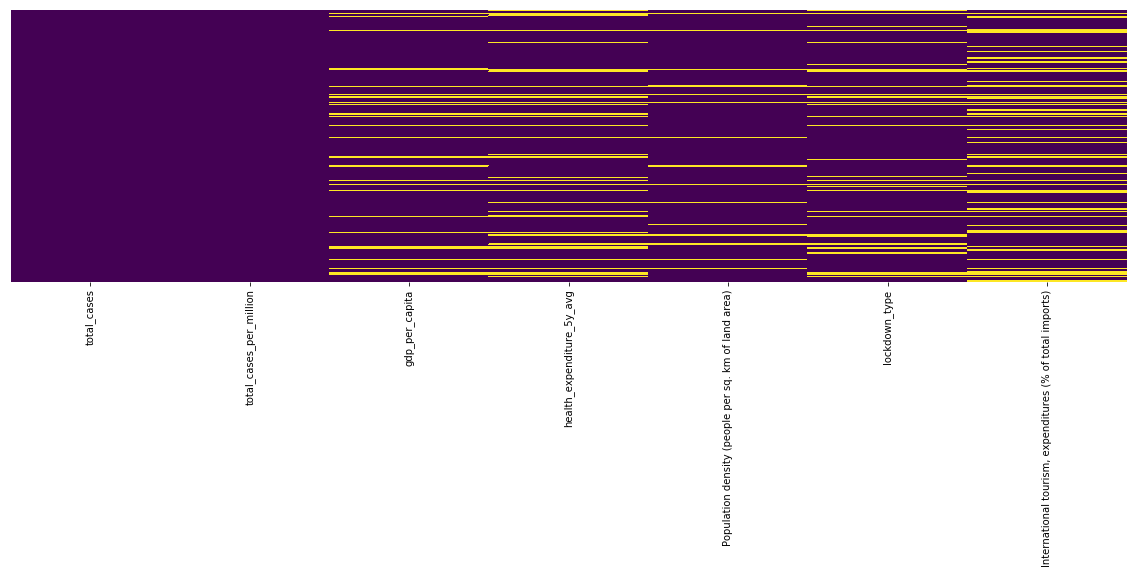

In [8]:
print(df_cases.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_cases.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_cases.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)",imports,"GNI, PPP (current international $)"
"International tourism, expenditures (% of total imports)",1,0.059,-0.054,0.011
"International tourism, expenditures (current US$)",0.059,1,0.93,0.93
imports,-0.054,0.93,1,0.92
"GNI, PPP (current international $)",0.011,0.93,0.92,1


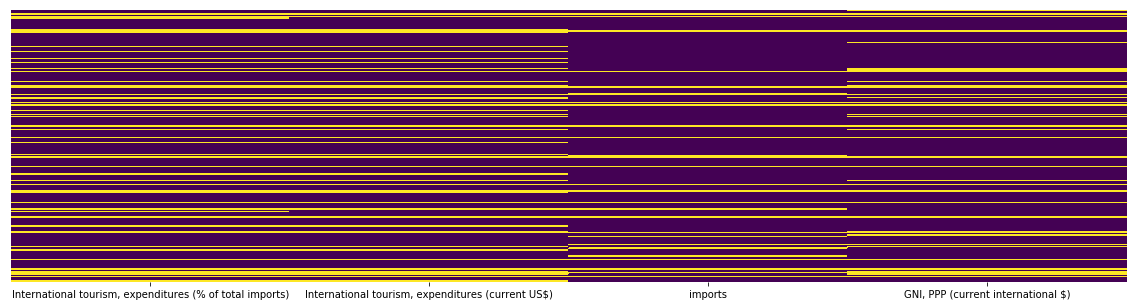

In [9]:
df_tourism = df_complete.loc[:, ["International tourism, expenditures (% of total imports)",
                                 "International tourism, expenditures (current US$)",
                                 "imports",
                                 "GNI, PPP (current international $)"]]

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_tourism.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_tourism.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

To fill up missing values for `International tourism, expenditures (% of total imports)` we try to predict the expenditures based on GNI (correlation 93%) and divide this by value of imported goods.

(154, 2)
[8.22635242e+09 1.75506675e+09 1.76099010e+09 1.41145346e+09
 1.41922636e+09 2.33186685e+09 1.53405233e+09 1.68265282e+09
 1.58519983e+09 3.66528853e+09 2.40737684e+09 1.82566069e+09
 1.57352332e+09 1.75010462e+09 2.16076365e+09 1.92302437e+09
 1.62705917e+09 1.50103910e+09 1.87574594e+09]
19 values were added with our prediction


,"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)",imports,"GNI, PPP (current international $)",prediction
"International tourism, expenditures (% of total imports)",1,0.059,-0.054,0.011,1
"International tourism, expenditures (current US$)",0.059,1,0.93,0.93,0.058
imports,-0.054,0.93,1,0.92,-0.0052
"GNI, PPP (current international $)",0.011,0.93,0.92,1,0.047
prediction,1,0.058,-0.0052,0.047,1


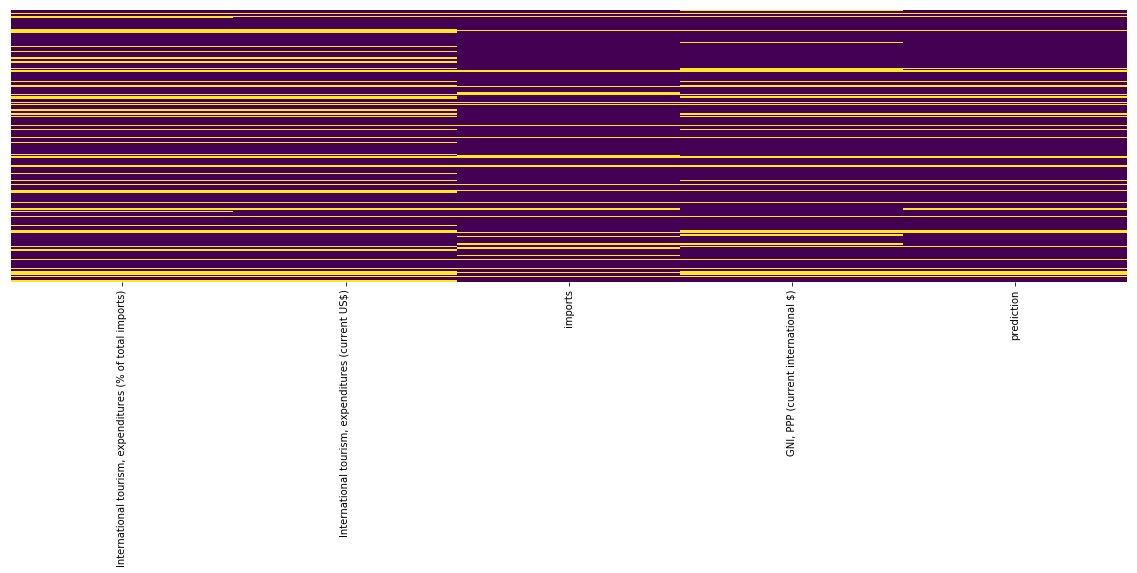

In [10]:
df_tourism_for_prediction = df_tourism.loc[:, ["International tourism, expenditures (current US$)",
                                              "GNI, PPP (current international $)"]].dropna()
print(df_tourism_for_prediction.shape)

X = df_tourism_for_prediction.drop("International tourism, expenditures (current US$)", axis=1)
y = df_tourism_for_prediction["International tourism, expenditures (current US$)"]

regressor = LinearRegression()
regressor.fit(X, y)

X_pred = pd.DataFrame(data={}, columns=['GNI, PPP (current international $)'])
i = 0
for index, row in df_tourism.iterrows():
  if (math.isnan(row["International tourism, expenditures (% of total imports)"])
    and not math.isnan(row["GNI, PPP (current international $)"])):
    X_pred.loc[i] = [row["GNI, PPP (current international $)"]]
    i+=1

y_pred = regressor.predict(X_pred)
print(y_pred)

i=0
new_values = []
for index, row in df_tourism.iterrows():
    if (math.isnan(row["International tourism, expenditures (% of total imports)"])
        and not math.isnan(row["GNI, PPP (current international $)"])):
        new_values.append(y_pred[i] / row["imports"])
        i+=1
    else:
        new_values.append(row["International tourism, expenditures (% of total imports)"])
df_tourism["prediction"] = new_values
print(i, "values were added with our prediction")

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_tourism.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_tourism.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Filling up missing values worked pretty good. Now we can add our predicted values to the existing ones. As visible below this increased the number of datasets without missing values from 140 to 156.

(156, 7)


,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)"
total_cases,1,0.2,0.16,0.3,-0.027,0.016
total_cases_per_million,0.2,1,0.61,0.093,0.2,0.23
gdp_per_capita,0.16,0.61,1,0.21,0.29,0.19
health_expenditure_5y_avg,0.3,0.093,0.21,1,-0.055,0.046
Population density (people per sq. km of land area),-0.027,0.2,0.29,-0.055,1,0.056
"International tourism, expenditures (% of total imports)",0.016,0.23,0.19,0.046,0.056,1


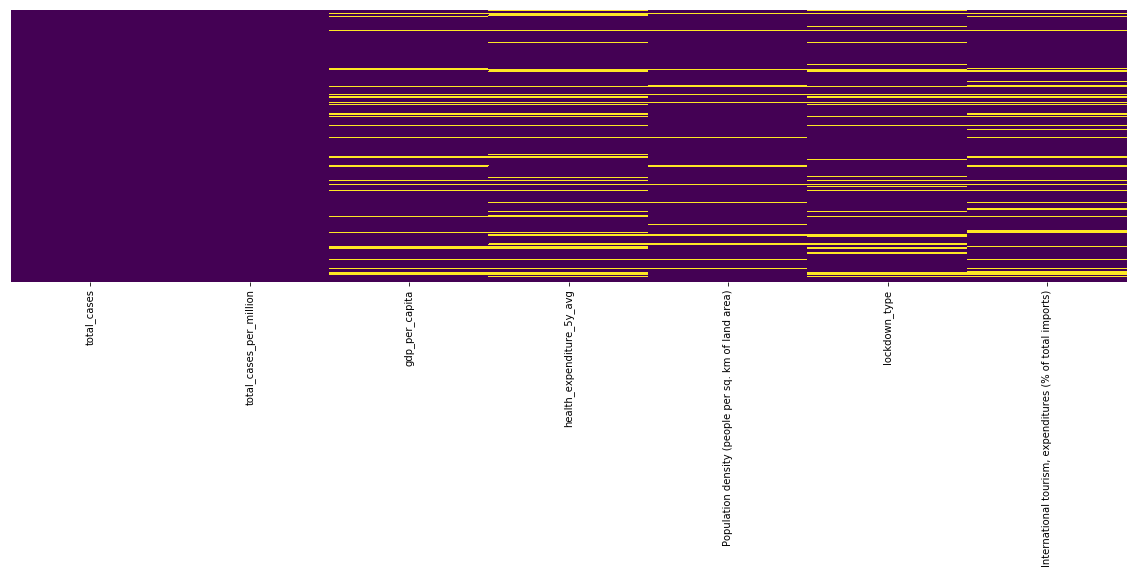

In [11]:
df_cases["International tourism, expenditures (% of total imports)"] = df_tourism["prediction"]

print(df_cases.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_cases.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_cases.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [13]:
df_cases["iso_code"] = df_complete["iso_code"]
df_cases["location"] = df_complete["location"]
df_cases.dropna().to_csv('./computed/cases.csv', sep=',', encoding='utf-8', index=False)